# Чекпойнт №3 — ML. Бейзлайны на HAM10000

**Задача.** Классификация изображений кожных новообразований (single-label, multi-class).

**Ключевая метрика.** `Macro F1` — из-за дисбаланса классов (редкие классы важны не меньше популярных).  
Вспомогательная: `ROC-AUC (macro)`.

**Данные.** HAM10000. После EDA получен `data/raw/labels_clean.csv` (битые/микро-изображения/точные дубли исключены).  
Сплиты: стратифицированно 70/15/15, `random_state=42`.

**План бейзлайнов.**
1) *Classic ML:* эмбеддинги ResNet-18 → Logistic Regression и KNN.  
2) *DL:* ResNet-18 с замороженным backbone (обучаем только «голову»), лёгкие аугментации.

Артефакты сохраняю в `plots/`, `results/`, `data/splits/`.


In [3]:
!pip -q install numpy pandas matplotlib pillow scikit-learn tqdm torchvision

from google.colab import drive; drive.mount('/content/drive')
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

ROOT   = "/content/drive/MyDrive/project1_ML"
LABELS = f"{ROOT}/data/raw/labels_clean.csv"
IMG_DIR= f"{ROOT}/data/raw/images"

for d in ("data/splits","plots","results","models"):
    os.makedirs(f"{ROOT}/{d}", exist_ok=True)

assert os.path.exists(LABELS), "Нет labels_clean.csv — вернись к EDA."

Mounted at /content/drive


## Метрика и сплиты
Ключевая метрика — **Macro F1**: усредняем F1 по классам, что честно для дисбаланса.  
Вспомогательная — **ROC-AUC (macro)** по вероятностям.  
Делаю стратифицированные сплиты 70/15/15, чтобы доли классов сохранялись.

Классы: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] | N= 10015


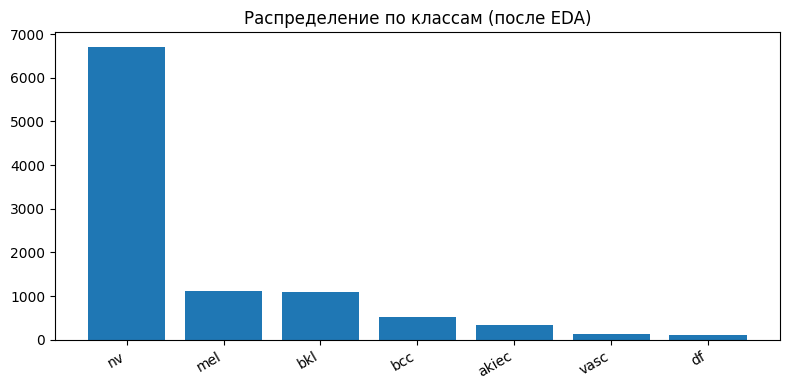

(7010, 1502, 1503)

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

data = pd.read_csv(LABELS)
le = LabelEncoder()
data["y"] = le.fit_transform(data["label"])
classes = le.classes_.tolist()
print("Классы:", classes, "| N=", len(data))

# график дисбаланса
cc = data["label"].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,4))
plt.bar(cc.index.astype(str), cc.values)
plt.xticks(rotation=30, ha="right"); plt.title("Распределение по классам (после EDA)")
plt.tight_layout(); plt.savefig(f"{ROOT}/plots/class_distribution.png", dpi=150); plt.show()

train_df, temp_df = train_test_split(data, test_size=0.30, stratify=data["y"], random_state=42)
val_df,   test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["y"], random_state=42)

train_df.to_csv(f"{ROOT}/data/splits/train.csv", index=False)
val_df.to_csv(f"{ROOT}/data/splits/val.csv", index=False)
test_df.to_csv(f"{ROOT}/data/splits/test.csv", index=False)

len(train_df), len(val_df), len(test_df)

## Бейзлайн 1: Classic ML (ResNet-18 embeddings → ML-классификатор)
1) Извлекаю 512-D эмбеддинги из ResNet-18 предобученной на ImageNet.  
2) Обучаю Logistic Regression (подбор `C`) и KNN (k∈{3,5,7}).  
3) Оцениваю на валидации: Macro F1 + ROC-AUC (macro).

In [5]:
import torch, torch.nn as nn, torchvision as tv
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

try:
    from torchvision.models import resnet18, ResNet18_Weights
    weights = ResNet18_Weights.IMAGENET1K_V1
    IM_MEAN, IM_STD = weights.meta["mean"], weights.meta["std"]
    def get_resnet18(): return resnet18(weights=weights)
except Exception:
    from torchvision.models import resnet18
    IM_MEAN, IM_STD = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    def get_resnet18(): return resnet18(pretrained=True)

transform_eval = tv.transforms.Compose([
    tv.transforms.Resize(256),
    tv.transforms.CenterCrop(224),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=IM_MEAN, std=IM_STD),
])

class ImgDS(Dataset):
    def __init__(self, df): self.df=df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, i):
        p=self.df.loc[i,"path"]; y=self.df.loc[i,"y"]
        img=Image.open(p).convert("RGB")
        return transform_eval(img), y

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def extract_embeddings(df, bs=64):
    base = get_resnet18().to(DEVICE).eval()
    backbone = nn.Sequential(*list(base.children())[:-1]).to(DEVICE)
    dl = DataLoader(ImgDS(df), batch_size=bs, shuffle=False, num_workers=2)
    feats, ys = [], []
    with torch.no_grad():
        for x,y in tqdm(dl, desc="Embeddings"):
            x=x.to(DEVICE)
            f=backbone(x).squeeze(-1).squeeze(-1).cpu().numpy()
            feats.append(f); ys.append(y.numpy())
    import numpy as np
    return np.concatenate(feats), np.concatenate(ys)

Xtr,ytr = extract_embeddings(train_df)
Xva,yva = extract_embeddings(val_df)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 81.7MB/s]
Embeddings: 100%|██████████| 24/24 [06:16<00:00, 15.69s/it]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg: {'macro_f1': 0.5475826940423604, 'roc_auc_macro': np.float64(0.9192339405528341)}
KNN   : {'macro_f1': 0.5237978739737773, 'k': 3, 'roc_auc_macro': np.float64(0.8328963986395055)}


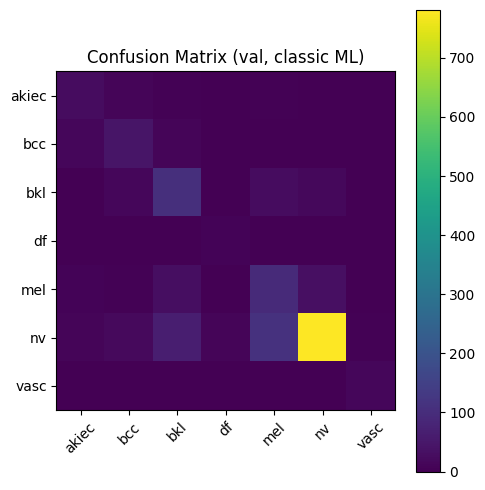

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
import numpy as np, json

# Logistic Regression
pipe = make_pipeline(StandardScaler(with_mean=True),
                     LogisticRegression(max_iter=5000, solver="saga", class_weight="balanced", n_jobs=-1))
grid = {"logisticregression__C":[0.1,1.0,10.0]}
cv   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs   = GridSearchCV(pipe, grid, scoring="f1_macro", cv=cv, n_jobs=-1, refit=True)
gs.fit(Xtr, ytr)
pred_lr, proba_lr = gs.predict(Xva), gs.predict_proba(Xva)
rep_lr = {"macro_f1": f1_score(yva, pred_lr, average="macro", zero_division=0)}
try: rep_lr["roc_auc_macro"] = roc_auc_score(yva, proba_lr, multi_class="ovr", average="macro")
except: pass

# KNN
best=None
for k in [3,5,7]:
    knn=KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(Xtr,ytr)
    pv=knn.predict(Xva); pp=knn.predict_proba(Xva)
    f1=f1_score(yva, pv, average="macro", zero_division=0)
    if best is None or f1>best[0]: best=(f1,k,pv,pp)
rep_knn={"macro_f1":best[0], "k":best[1]}
try: rep_knn["roc_auc_macro"]=roc_auc_score(yva, best[3], multi_class="ovr", average="macro")
except: pass

print("LogReg:", rep_lr)
print("KNN   :", rep_knn)

with open(f"{ROOT}/results/classic_val.json","w") as f:
    json.dump({"logreg":rep_lr, "knn":rep_knn}, f, indent=2)

# матрица ошибок лучшей классической модели
use_pred = pred_lr if rep_lr["macro_f1"]>=rep_knn["macro_f1"] else best[2]
plt.figure(figsize=(5,5))
cm = confusion_matrix(yva, use_pred, labels=list(range(len(classes))))
plt.imshow(cm); plt.title("Confusion Matrix (val, classic ML)")
plt.xticks(range(len(classes)), classes, rotation=45); plt.yticks(range(len(classes)), classes)
plt.colorbar(); plt.tight_layout(); plt.savefig(f"{ROOT}/plots/confusion_matrix_val_classic.png", dpi=150); plt.show()

## Бейзлайн 2: DL (ResNet-18, frozen backbone)
Замораживаю все слои, обучаю только финальную линейную «голову» ~10 эпох.  
Аугментации: RandomResizedCrop(224, 0.8–1.0), HorizontalFlip(0.5).  
Метрики: Macro F1 и ROC-AUC (macro) на валидации.

In [7]:
import torch.nn as nn, torch, torchvision as tv
from torch.utils.data import DataLoader

transform_train = tv.transforms.Compose([
    tv.transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    tv.transforms.RandomHorizontalFlip(p=0.5),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=IM_MEAN, std=IM_STD),
])

class ImgTrainDS(ImgDS):
    def __getitem__(self, i):
        p=self.df.loc[i,"path"]; y=self.df.loc[i,"y"]
        img=Image.open(p).convert("RGB")
        return transform_train(img), y

train_dl = DataLoader(ImgTrainDS(train_df), batch_size=64, shuffle=True,  num_workers=2)
val_dl   = DataLoader(ImgDS(val_df),        batch_size=64, shuffle=False, num_workers=2)

model = get_resnet18().to(DEVICE)
for p in model.parameters(): p.requires_grad=False
in_f = model.fc.in_features
model.fc = nn.Linear(in_f, len(classes)).to(DEVICE)

crit = nn.CrossEntropyLoss()
opt  = torch.optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

from sklearn.metrics import f1_score, roc_auc_score
import numpy as np, json

def eval_val(m):
    m.eval(); Y,P,PR=[],[],[]
    with torch.no_grad():
        for x,y in val_dl:
            x=x.to(DEVICE); y=y.to(DEVICE)
            logits=m(x); proba=torch.softmax(logits,dim=1); pred=proba.argmax(1)
            Y.append(y.cpu().numpy()); P.append(pred.cpu().numpy()); PR.append(proba.cpu().numpy())
    y=np.concatenate(Y); p=np.concatenate(P); pr=np.concatenate(PR)
    out={"macro_f1": f1_score(y,p,average="macro",zero_division=0)}
    try: out["roc_auc_macro"]=roc_auc_score(y, pr, multi_class="ovr", average="macro")
    except: pass
    return out

best_rep=None; best_state=None
for ep in range(1,11):
    model.train()
    for x,y in train_dl:
        x=x.to(DEVICE); y=y.to(DEVICE)
        opt.zero_grad(); loss=crit(model(x), y); loss.backward(); opt.step()
    rep = eval_val(model)
    print(f"Epoch {ep:02d}: F1={rep['macro_f1']:.4f}")
    if best_rep is None or rep["macro_f1"]>best_rep["macro_f1"]:
        best_rep=rep; best_state={k:v.cpu() for k,v in model.state_dict().items()}

torch.save(best_state, f"{ROOT}/models/resnet18_frozen_best.pth")
with open(f"{ROOT}/results/dl_val.json","w") as f: json.dump(best_rep, f, indent=2)
print("DL best @val:", best_rep)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01: F1=0.2932
Epoch 02: F1=0.3216
Epoch 03: F1=0.4094
Epoch 04: F1=0.4672
Epoch 05: F1=0.4899
Epoch 06: F1=0.5353
Epoch 07: F1=0.5194
Epoch 08: F1=0.5710
Epoch 09: F1=0.5358
Epoch 10: F1=0.5216
DL best @val: {'macro_f1': 0.5710375702573873, 'roc_auc_macro': np.float64(0.9387915504850929)}


## Результаты и выводы
Ключевая метрика — Macro F1 (из-за дисбаланса).  
Сравниваю classic-подход (эмбеддинги → ML) и простой DL с замороженным backbone.

In [8]:
import json, pandas as pd, os

def load_json(p):
    return json.load(open(p)) if os.path.exists(p) else {}

classic = load_json(f"{ROOT}/results/classic_val.json")
dl      = load_json(f"{ROOT}/results/dl_val.json")

rows=[]
if "logreg" in classic: rows.append(("Classic:LogReg", classic["logreg"].get("macro_f1"), classic["logreg"].get("roc_auc_macro")))
if "knn"    in classic: rows.append((f"Classic:KNN(k={classic['knn']['k']})", classic["knn"]["macro_f1"], classic["knn"].get("roc_auc_macro")))
if dl: rows.append(("DL:ResNet18(frozen)", dl.get("macro_f1"), dl.get("roc_auc_macro")))
res = pd.DataFrame(rows, columns=["model","macro_f1","roc_auc_macro"]).sort_values("macro_f1", ascending=False)
res

,model,macro_f1,roc_auc_macro
2,DL:ResNet18(frozen),0.571038,0.938792
0,Classic:LogReg,0.547583,0.919234
1,Classic:KNN(k=3),0.523798,0.832896


In [10]:
res_round = res.copy()
for c in ["macro_f1","roc_auc_macro"]:
    res_round[c] = res_round[c].astype(float).round(3)
res_round

,model,macro_f1,roc_auc_macro
2,DL:ResNet18(frozen),0.571,0.939
0,Classic:LogReg,0.548,0.919
1,Classic:KNN(k=3),0.524,0.833


## Итоги (val)

**Ключевая метрика — Macro F1** (из-за дисбаланса): оценивает качество равномерно по всем классам.
Вспомогательная — ROC-AUC (macro).

**Результаты (валидация):**
- Classic ML (ResNet-18 эмбеддинги → LogisticRegression): **Macro F1 = 0.548**, ROC-AUC = 0.919.
- Classic ML (KNN, k=3): **Macro F1 = 0.524**, ROC-AUC = 0.833.
- **DL (ResNet-18, frozen backbone): Macro F1 = 0.571**, ROC-AUC = 0.939.

**Выводы.**
1. Эмбеддинги + логрега дают сильный и быстрый бейзлайн; KNN уступает.
2. Простая DL-модель с замороженным backbone даёт лучший Macro F1, оставаясь устойчивой.
3. Основные ошибки — перетекание в «массовый» класс `nv` и путаница пар `bkl↔bcc`, `mel↔nv`.

**Дальше (к MVP):**
- балансировка редких классов (class weights / WeightedRandomSampler, Focal Loss),
- частичный fine-tune последних блоков ResNet-18 (малый lr),
- чуть сильнее аугментации (ColorJitter, небольшие повороты), HPO (lr, wd, epochs), ↑размер входа.
